https://www.kaggle.com/learn/time-series

In [ ]:
import kagglehub
import pandas as pd


In [ ]:
# import data
path = kagglehub.dataset_download("ryanholbrook/ts-course-data")
print("Path to dataset files:", path)

# parse_dates=["Day"]: automatically convert the "Day" column into a datetime object, instead of keeping it as a string
data = pd.read_csv(f"{path}/tunnel.csv", parse_dates=["Day"])
data.head()

# Create a time series in Pandas by setting the index to a date column.
data = data.set_index("Day")


# By default, Pandas creates a `DatetimeIndex` with dtype `Timestamp`
# (equivalent to `np.datetime64`, representing a time series as a
# sequence of measurements taken at single moments. A `PeriodIndex`,
# on the other hand, represents a time series as a sequence of
# quantities accumulated over periods of time. Periods are often
# easier to work with, so that's what we'll use in this course.
data = data.to_period()

data.head()

Path to dataset files: /root/.cache/kagglehub/datasets/ryanholbrook/ts-course-data/versions/14


,NumVehicles
Day,
2003-11-01,103536
2003-11-02,92051
2003-11-03,100795
2003-11-04,102352
2003-11-05,106569


# Linear Regression with Time Series

In [ ]:
# Linear Regression:
# target = w_1*feature_1 + w_2 * feature_2 + ... + bias

plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)



In [ ]:
import numpy as np

# create a time dummy

df = data.copy()

print(len(df.index))

df['Time'] = np.arange(len(df.index))

df.head()

747


,NumVehicles,Time
Day,,
2003-11-01,103536,0
2003-11-02,92051,1
2003-11-03,100795,2
2003-11-04,102352,3
2003-11-05,106569,4


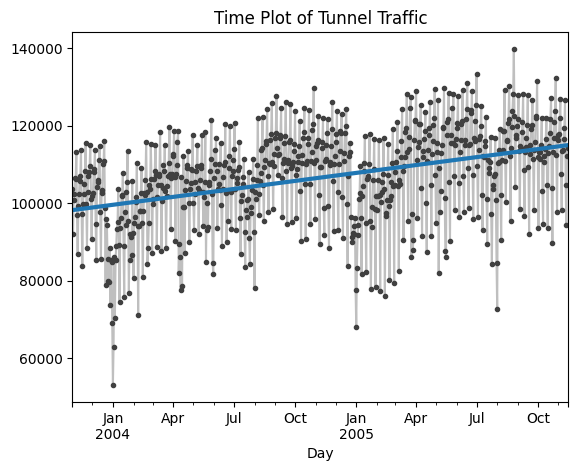

In [ ]:
# fit a linear regression model
from sklearn.linear_model import LinearRegression

# The double brackets ([['Time']]) ensure that
# X is a DataFrame rather than a Series.
x = df.loc[:, ['Time']]
y = df.loc[:, 'NumVehicles']

model = LinearRegression()
model.fit(x, y)

# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(x), index = x.index)


ax = y.plot(**plot_params)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of Tunnel Traffic');

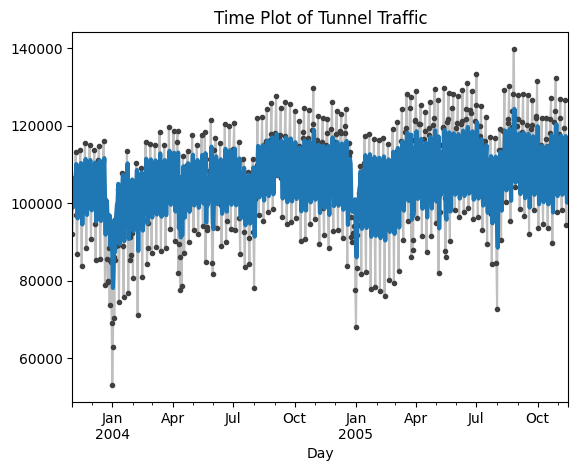

In [ ]:
# lag feature
from sklearn.linear_model import LinearRegression

df['Lag_1'] = df['NumVehicles'].shift(1)
x = df.loc[:,['Lag_1']]
x.dropna(inplace=True)
y = df.loc[:, 'NumVehicles']

y,x = y.align(x, join = 'inner') # drop corresponding values in target

model = LinearRegression()
model.fit(x, y)

y_pred = pd.Series(model.predict(x), index=x.index)

ax = y.plot(**plot_params)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of Tunnel Traffic');

# Trend

In [ ]:
# The trend component of a time series represents a persistent, long-term change in the mean of the series.

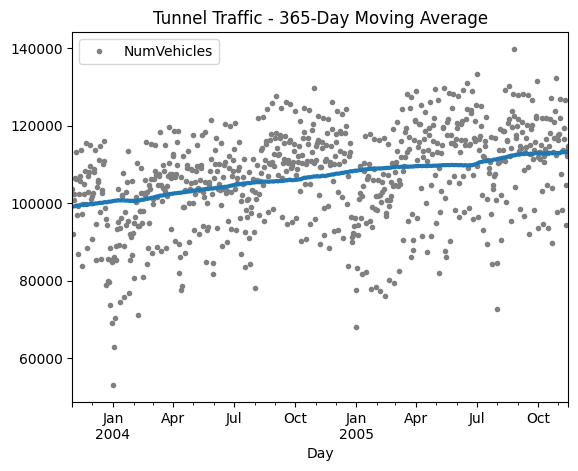

In [ ]:
# get rolling average

moving_average = data.rolling(
    window = 365,
    center = True, # center at the middle of the windows
    min_periods = 183,
).mean()

ax = data.plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="Tunnel Traffic - 365-Day Moving Average", legend=False,
);


In [ ]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index=data.index,
    constant=True, # dummy feature for the bias (y_intercept)
    order = 1, # time dummy linear
    drop= True, # drop terms if necessary to avoid collinearity
)

# `in_sample` creates features for the dates given in the `index` argument
X = dp.in_sample()

X.head()

,const,trend
Day,,
2003-11-01,1.0,1.0
2003-11-02,1.0,2.0
2003-11-03,1.0,3.0
2003-11-04,1.0,4.0
2003-11-05,1.0,5.0


In [ ]:
# Linear Regression model with moving average as x

from sklearn.linear_model import LinearRegression

y = data['NumVehicles']

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

In [ ]:
# make a forcast

X = dp.out_of_sample(steps = 30) # 30 days

y_fore = pd.Series(model.predict(X), index=X.index)
y_fore.head()

,0
2005-11-17,114981.801146
2005-11-18,115004.298595
2005-11-19,115026.796045
2005-11-20,115049.293494
2005-11-21,115071.790944


# Seasonality

In [ ]:
# seasonality: a regular, periodic change in the mean of the series
# two kinds of features that model seasonality.
# 1. indicators, is best for a season with few observations, like a weekly season of daily observations.
# 2. Fourier features, is best for a season with many observations, like an annual season of daily observations.

In [ ]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'


# annotations: https://stackoverflow.com/a/49238256/5769929
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

In [ ]:
tunnel = data.copy()
tunnel = tunnel.set_index("Day").to_period("D")

X = tunnel.copy()

# days within a week
X["day"] = X.index.dayofweek  # the x-axis (freq)
X["week"] = X.index.week  # the seasonal period (period)

# days within a year
X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(X, y="NumVehicles", period="week", freq="day", ax=ax0)
seasonal_plot(X, y="NumVehicles", period="year", freq="dayofyear", ax=ax1);

KeyError: "None of ['Day'] are in the columns"

# Time Series as Feature (Cycles and Lags)

In [ ]:
# Cycles: one common way of serial dependence. Difference is that cycles does not depend on
# the time itself, but the value at the previous time
# Lag: By lagging a time series, we can make its past values appear contemporaneous with the values we are trying to predict
#  (in the same row, in other words). This makes lagged series useful as features for modeling serial dependence.

# Hybrid models

In [ ]:
# Three patterns of dependence: trend, seasons, and cycles.
#   Many time series can be closely described by an additive model of just these three components
#   plus some essentially unpredictable, entirely random error:
#   series = trend + seasons + cycles + error
#   residual is the result of subtracting a series with a component

# Generally two ways a regression algorithm can make predictions:
# 1. transforming the features: Like linear regression and neural nets
# 2. transforming the target: Decision trees and nearest neighbors
# transforming features cannot extrapolate, always be bound within the range of the training set

This difference is what motivates the hybrid design in this lesson: use linear regression to extrapolate the trend, transform the target to remove the trend, and apply XGBoost to the detrended residuals. **To hybridize a neural net (a feature transformer), you could instead include the predictions of another model as a feature, which the neural net would then include as part of its own predictions.**

The method of fitting to residuals is actually the same method the gradient boosting algorithm uses, so we will call these **boosted hybrids**; the method of using predictions as features is known as "stacking", so we will call these **stacked hybrids**.

# Forecasting With Machine Learning

Four methods:
1. multiple output model: train a multiple output model, such as linear regression
2. direct method: Train a separate model for each step in the horizon: one model forecasts 1-step ahead, another 2-steps ahead, and so on

3. recursive method: Train a single one-step model and use its forecasts to update the lag features for the next step.

4. Direc method: Combination of the direct and recursive strategies: train a model for each step and use forecasts from previous steps as new lag features.